# Import Packages

In [4]:
# !pip install pydicom

In [5]:
import pydicom
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import random
import os

import torch

# Deep learning framework
import torch
print(torch.__version__)
print(torch.version.cuda)
print(torch.backends.cudnn.version())
print(torch.cuda.is_available())

import torch.nn as nn

from torchvision.transforms import v2

from sklearn.model_selection import train_test_split

2.4.1+cu118
11.8
90100
True


# DICOM file

1.   檢視: [ImageJ](https://imagej.nih.gov/ij/download.html)
2.   讀取: pydicom


In [6]:
# A configurable is a regular Python class that serves as a base class for all main classes in an application.
class config: 
    root = "./hwk02_data"
    batch_size = 16
    seed = 42

## DICOM information
1. File Meta Information：例如 SOP Class UID、Instance UID、Transfer Syntax UID 等，描述該影像檔的格式和識別資訊。
2. Patient Information：包含病人的名字、年齡、性別、出生日期等資料。
3. Image Information：包括影像的類型（如核醫學影像）、時間（檢查日期、取得影像的時間）、檢查描述（如腦部掃描）、影像幀數（20 幀）、每像素的樣本數（1，即單色影像），影像尺寸（128x128），Pixel Spacing 等。
4. Radiopharmaceutical Information：這部分顯示了使用的藥物劑量與相關的放射性核素資料。
5. Pixel Data：最終列出了影像的像素數據，包括每幀影像的最低與最高像素值等資訊。

In [7]:
dicom_path = '/DICOM/A1406/00010019'
dicom_file = pydicom.dcmread(config.root + dicom_path)
print(dicom_file)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 190
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Nuclear Medicine Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.12.2.1107.5.6.1.11086.30210113010906485384300000002
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7238010.5.0.3.5.4
(0002, 0013) Implementation Version Name         SH: 'OSIRIX'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'RECON TOMO', 'EMISSION']
(0008, 0016) SOP Class UID                       UI: Nuclear Medicine Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.12.2.1107.5.6.1.11086.30210113010906485384300000002
(

In [8]:
# Window Width：視窗的寬度，用來控制影像的對比度。   
# Window Center：視窗的中心位置，用來控制影像的亮度。

print(f"({dicom_file.WindowCenter}, {dicom_file.WindowWidth})")

(141, 283)


In [9]:
images = dicom_file.pixel_array
print(images.shape)

(20, 128, 128)


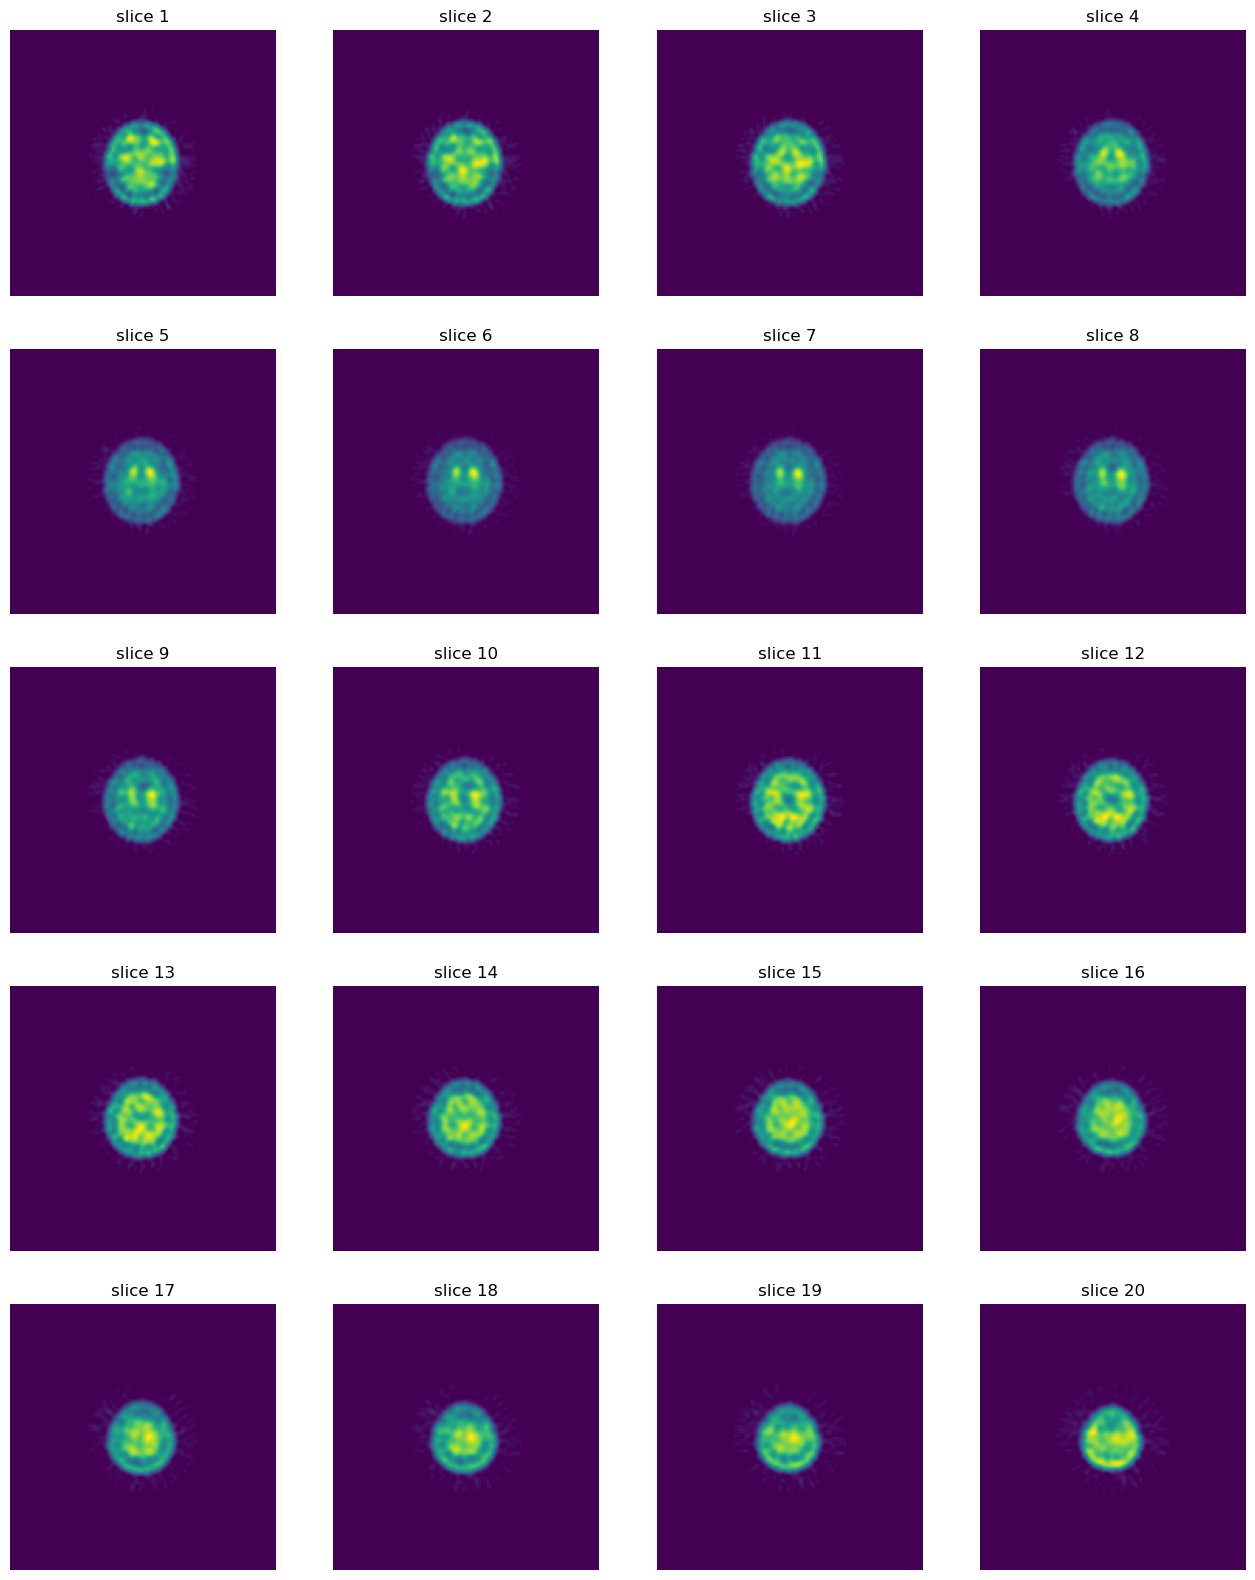

In [10]:
# 每位 patient 的 slice 數不一定一樣，這邊畫出這位 patient 的 20 張 slice

plt.figure(figsize = (16, 20))
for i in range(images.shape[0]):
    plt.subplot(5,4,i+1)
    
    # 若 imshow 加入 cmap = 'gray'，則可以得到原先灰階的 slice 圖。
    plt.imshow(images[i])
    
    plt.title(f'slice {i+1}')
    plt.axis('off')
    plt.subplots_adjust(wspace = None, hspace = None)

# train.csv


In [11]:
train_data = pd.read_csv(os.path.join(config.root, 'train.csv'))
train_data

,ID,Age,Gender,FilePath,index,Stage
0,A175204,69,0,/DICOM/A175204/00010018,7,1
1,A122221,56,0,/DICOM/A122221/00010034,15,1
2,A54671,82,0,/DICOM/A54671/00010021,8,1
3,A31117,71,1,/DICOM/A31117/00010022,10,1
4,A653195,68,0,/DICOM/A653195/00010016,7,1
...,...,...,...,...,...,...
156,A717094,80,1,/DICOM/A717094/00010022,11,3
157,A741758,54,1,/DICOM/A741758/00010017,9,3
158,A646753,75,1,/DICOM/A646753/00010023,12,3
159,A679904,62,1,/DICOM/A679904/00010020,9,3


# test.csv

In [12]:
test_data = pd.read_csv(os.path.join(config.root, 'test.csv'))
test_data

,ID,Age,Gender,FilePath,index,Stage
0,A152206,64,1,/DICOM/A152206/00010023,11,NaN
1,A42278,72,1,/DICOM/A42278/00010022,10,NaN
2,A306881,89,0,/DICOM/A306881/00010033,19,NaN
3,A289458,44,0,/DICOM/A289458/00010035,16,NaN
4,A518725,72,0,/DICOM/A518725/00010022,9,NaN
5,A737619,56,1,/DICOM/A737619/00010023,10,NaN
6,A194289,74,1,/DICOM/A194289/00010023,9,NaN
7,A741991,71,1,/DICOM/A741991/00010021,7,NaN
8,A29870,79,0,/DICOM/A29870/00010019,6,NaN
9,X691,39,0,/DICOM/X691/00010023,10,NaN


# Pytorch Dataset


1. getitem: 讓定義的類別可以迭代調用。
2. call: 讓定義的類別可以像普通函數一樣，直接用類別名稱(參數)就可以呼叫。

In [13]:
class ParkinsonsDataset(torch.utils.data.Dataset):

    def __init__(self, df, transforms = None): # 將所有資料提出
        self.df = df
        self.transforms = transforms
        
    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, x):
        
        age = torch.tensor(self.df.iloc[x, 1]) # 年齡
        gender = torch.tensor(self.df.iloc[x, 2]) # 性別
        index = torch.tensor(self.df.iloc[x, 4]) # 起始張數
        label = torch.tensor(self.df.iloc[x, 5]) # 標籤
        
        # 影像前處理
        image = pydicom.dcmread(config.root + self.df.iloc[x, 3]).pixel_array
        
        # DICOM 文件中的圖像數據通常以整數 (int16, uint16 等) 格式存儲，為了確保後續計算的精度及穩定性，所以使用浮點數運算。
        image = torch.tensor(image.astype(np.float32))
        image = image[index-1:index+2, :, :] # 取指定張數和前後共 3 張，image size = [3, 128, 128]
#         image = image[[index]*3, :, :] # 取指定張數重疊共 3 張
        
        if self.transforms: image = self.transforms(image)
        
        return image, age, gender, label

## Transformation

In [14]:
# v2 中內建的影像處理 function

dir(v2)

['AugMix',
 'AutoAugment',
 'AutoAugmentPolicy',
 'CenterCrop',
 'ClampBoundingBoxes',
 'ColorJitter',
 'Compose',
 'ConvertBoundingBoxFormat',
 'ConvertImageDtype',
 'CutMix',
 'ElasticTransform',
 'FiveCrop',
 'GaussianBlur',
 'GaussianNoise',
 'Grayscale',
 'Identity',
 'InterpolationMode',
 'JPEG',
 'Lambda',
 'LinearTransformation',
 'MixUp',
 'Normalize',
 'PILToTensor',
 'Pad',
 'RGB',
 'RandAugment',
 'RandomAdjustSharpness',
 'RandomAffine',
 'RandomApply',
 'RandomAutocontrast',
 'RandomChannelPermutation',
 'RandomChoice',
 'RandomCrop',
 'RandomEqualize',
 'RandomErasing',
 'RandomGrayscale',
 'RandomHorizontalFlip',
 'RandomInvert',
 'RandomIoUCrop',
 'RandomOrder',
 'RandomPerspective',
 'RandomPhotometricDistort',
 'RandomPosterize',
 'RandomResize',
 'RandomResizedCrop',
 'RandomRotation',
 'RandomShortestSize',
 'RandomSolarize',
 'RandomVerticalFlip',
 'RandomZoomOut',
 'Resize',
 'SanitizeBoundingBoxes',
 'ScaleJitter',
 'TenCrop',
 'ToDtype',
 'ToImage',
 'ToPILImag

1. Min-Max Normalization 適合於將圖像值縮放到固定範圍時，特別是在進行像素範圍變換或需要穩定化不同圖像來源的數據時。
2. v2 的 normalize 更適合於深度學習中的圖像預處理，特別是在訓練神經網絡時，它可以使模型更好地學習特徵而不受像素值範圍的影響。

In [15]:
# 因為這邊是將 3 張灰階圖去做疊加所得到的 3 維圖，因此若是用 v2 內建的 normalize 可能會不合，但仍可嘗試看看。

class Min_Max_Normalization(object): # 自定義的類別
  # def __init__(self): # 宣告此類別中會使用到的資料

  def __call__(self, image): # 定義有image之後要進行的資料處理
    changed_image = (image - image.min())/(image.max() - image.min())
    return changed_image

Transforms = v2.Compose([
    
    # 在v2中裡的 function
    # 這邊可能要注意有可能切到想要的圖像
    v2.CenterCrop(size = (50, 50)),
    
    # 自定義的 function
    Min_Max_Normalization()
])

# EDA (Exploratory Data Analysis)

In [16]:
dataset = ParkinsonsDataset(train_data, transforms = Transforms)
test_dataset = ParkinsonsDataset(test_data, transforms = Transforms)

In [17]:
print(f"Number of training samples: {len(dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")

Number of training samples: 161
Number of testing samples: 41


In [18]:
train_labels = train_data.iloc[:, 5].value_counts().sort_index()
train_labels

Stage
1    44
2    42
3    75
Name: count, dtype: int64

## Bar chart

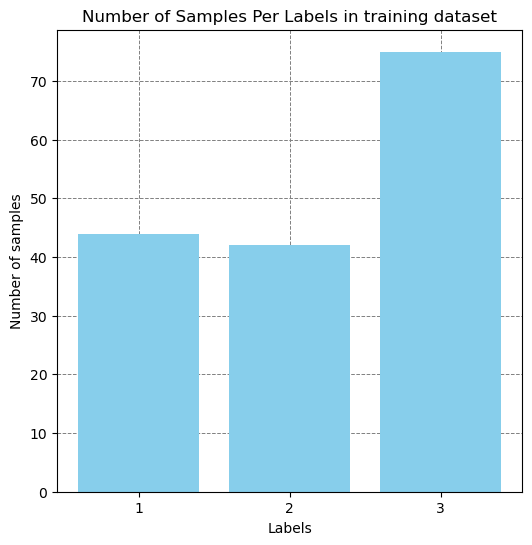

In [19]:
from matplotlib.ticker import MaxNLocator

labels, counts = train_labels.index, train_labels.values

plt.figure(figsize = (6, 6))

# 設定 zorder 為 2，讓長條圖在網格線上面顯示
plt.bar(labels, counts, color = 'skyblue', zorder = 2)

plt.xlabel('Labels')
plt.ylabel("Number of samples")
plt.title("Number of Samples Per Labels in training dataset")

# 設定 x 軸為整數
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

plt.grid(True, which = 'both', axis = 'both', linestyle = '--', color='gray', linewidth = 0.7, zorder = 1)


# 顯示圖表
plt.show()

In [20]:
sub_df = train_data[(train_data['Gender'] == 1) & (train_data['Stage'] == 1)]
print('男性且判斷為第1期的人數: ', sub_df.shape[0])

男性且判斷為第1期的人數:  18


male:  [18, 14, 31] , female:  [26, 28, 44]


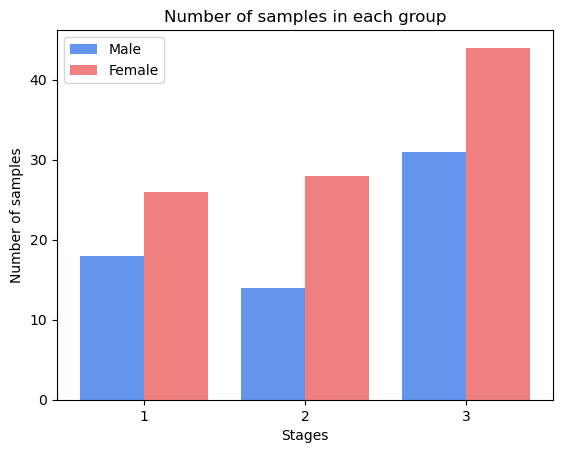

In [21]:
male = [train_data[(train_data['Gender'] == 1) & (train_data['Stage'] == i)].shape[0] for i in range(1, 4)]
female = [train_data[(train_data['Gender'] == 0) & (train_data['Stage'] == i)].shape[0] for i in range(1, 4)]
print('male: ', male, ', female: ',female)
x_axis = np.arange(len(labels))
plt.bar(x_axis - 0.2, male, 0.4, label = 'Male', color = 'cornflowerblue')
plt.bar(x_axis + 0.2, female, 0.4, label = 'Female', color = 'lightcoral')
plt.xticks(x_axis, labels)
plt.xlabel("Stages")
plt.ylabel("Number of samples")
plt.title("Number of samples in each group")
plt.legend()
plt.show()

## Box plot

orange line：代表該組的中位數，顯示年齡的中間值。  
box：顯示數據的第1四分位數（Q1）和第3四分位數（Q3）之間的範圍，為數據中間的50%。  
Whiskers：表示數據的範圍，不包括離群值。上鬚延伸至Q3+1.5IQR（四分位距），下鬚延伸至Q1-1.5IQR。  
Outliers (dots)：圖中圓點是超出 Whiskers 範圍的數據點，代表可能的離群值或極端值。  

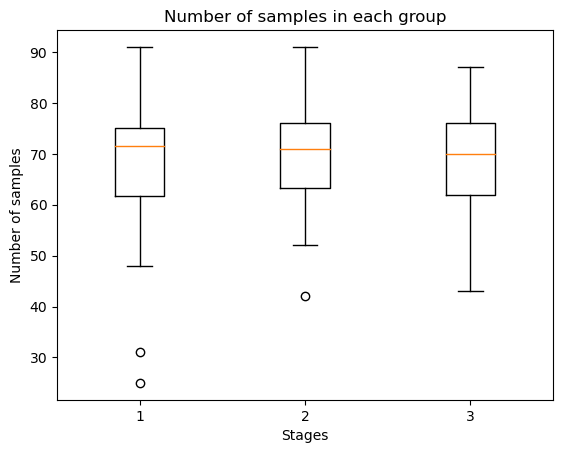

In [22]:
sub_df = [train_data[train_data['Stage'] == i]['Age'] for i in range(1, 4)]
plt.boxplot(sub_df)
plt.xlabel("Stages")
plt.ylabel("Number of samples")
plt.title("Number of samples in each group")
plt.show()

In [23]:
def outliers_IQR(data):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data < lower_bound) | (data > upper_bound)]

# 每組數據的極端值
for i, age_data in enumerate(sub_df, start=1):
    outliers = outliers_IQR(age_data)
    print(f"Stage {i} 的離群值: {outliers.values}")

Stage 1 的離群值: [25 31]
Stage 2 的離群值: [42]
Stage 3 的離群值: []


In [24]:
train_dataset, val_dataset = train_test_split(train_data, train_size = 0.8, test_size = 0.2, random_state = config.seed)

train_dataset = ParkinsonsDataset(train_dataset, transforms = Transforms)
val_dataset = ParkinsonsDataset(val_dataset, transforms = Transforms)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = config.batch_size, shuffle = True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = config.batch_size, shuffle = False)

因為 batch_size 設為 16 ，因此 dataloader 每次迭代中都是用 16 個樣本(patient)，而每位 patient 的 image 都是由 3 張 slice 組成，所以這邊畫出48張圖。

Image shape: torch.Size([16, 3, 50, 50]), label shape torch.Size([16])


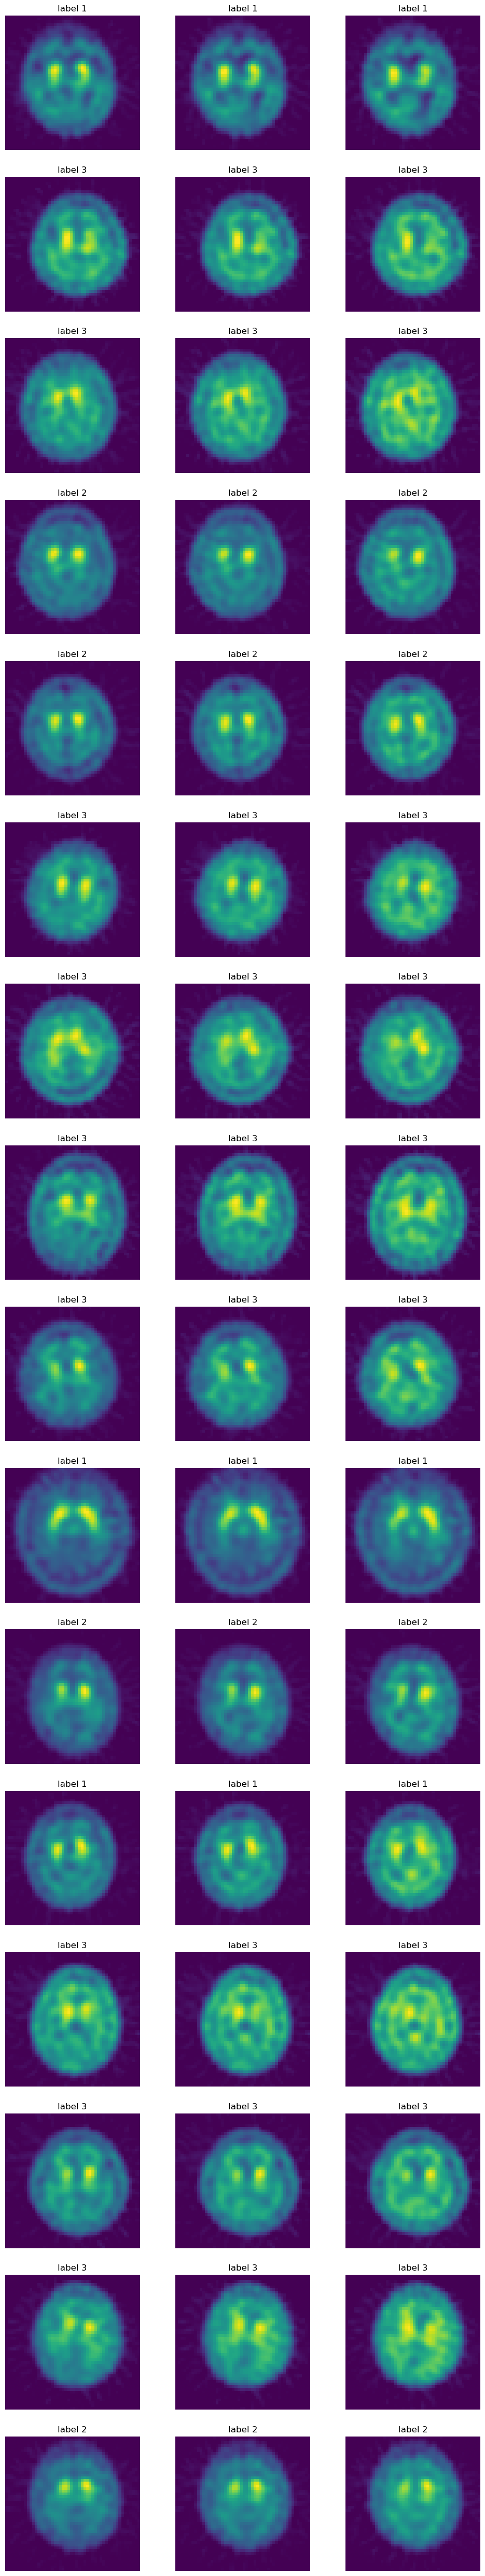

In [25]:
images, ages, genders, labels = next(iter(train_loader))

plt.figure(figsize = (12, 64)) # (寬, 長)

for i, (image ,label) in enumerate(zip(images, labels)):
    
    for j in range(3):
        
        plt.subplot(16, 3, i*3 +j+1)
        plt.title(f"label {label.numpy()}")
        plt.imshow(image[j])
        plt.axis('off')
        plt.subplots_adjust(wspace = None, hspace = None)

print(f"Image shape: {images.shape}, label shape {labels.shape}")